# Policy Evaluation

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 74, 4.1 - Policy Evaluation (Prediction)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## FrozenLake grid environment

Similar to https://gymnasium.farama.org/environments/toy_text/frozen_lake/

cell colors:

* white - empty cell
* red - hole, reward -1
* green - goal, reward +100

actions are slippery:
* P(move forward)=1/3
* P(move left)=1/3
* P(move right)=1/3

rewards:
* hole reward -1
* goal reward +100
* out of grid reward 0, game stops

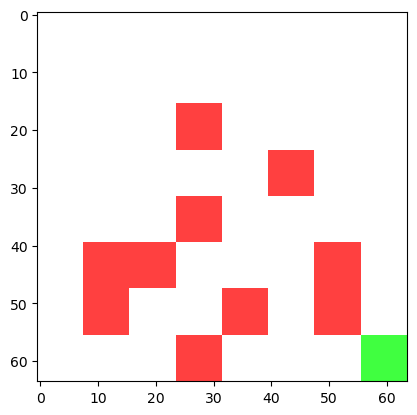

In [2]:
class FrozenLakeSimple:
    def __init__(self):
        self.N = 8
        self.board = [
            "FFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]
        self.start = (0, 0)

    def render(self):
        N = self.N
        board = self.board
        CELL_SIZE = 8

        img = np.zeros((N * CELL_SIZE, N * CELL_SIZE, 3), dtype=np.uint8)
        for r in range(N):
            for c in range(N):
                colors = {
                    'F': [255, 255, 255],
                    'H': [255, 64, 64],
                    'G': [64, 255, 64],
                }
                img[r * CELL_SIZE : (r + 1) * CELL_SIZE, c * CELL_SIZE : (c + 1) * CELL_SIZE, :] = colors[board[r][c]]
        plt.imshow(img)

    def get_reward_done(self, row, col):
        """
        Return reward for getting into the state (row, col)
        Return done flag
        """
        N = self.N
        board = self.board

        if 0 <= row < N and 0 <= col < N:
            sym = board[row][col]

            rewards = {'S': 0, 'H': -1, 'G': 100, 'F': 0}
            reward = rewards[sym]

            done = sym in 'HG'

            return reward, done

        # out of board
        return 0, True

problem = FrozenLakeSimple()
problem.render()

## Policy evaluation method, trivial policies

Policy is a probablity that agent takes action `a` in a state `s`

Here, state is a pair of coordinates (row, col), so policy is an matrix of size (8, 8, 4): element at `(row, col, dir)` is a probability to take direction dir staying in (row, col) cell

direction is a number:
* 0 - move up
* 1 - move right
* 2 - move down
* 3 - move left

In [3]:
DIRECTIONS = [
    (-1, 0),
    (0, 1),
    (1, 0),
    (0, -1)
]

def get_constant_policy(problem, dir):
    policy = np.zeros((problem.N, problem.N, 4))
    policy[:, :, dir] = 1
    return policy

def get_random_policy(problem):
    policy = np.random.rand(problem.N, problem.N, 4)
    for row in range(problem.N):
        for col in range(problem.N):
            policy[row, col, :] /= np.sum(policy[row, col, :])
    return policy

def render_policy_state_function(problem, policy_state_function):
    N, M = policy_state_function.shape
    CELL_SIZE = 100

    img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 255

    for r, c in np.ndindex(policy_state_function.shape):
        colors = {
            'F': [255, 255, 255],
            'H': [255, 64, 64],
            'G': [64, 255, 64],
        }
        img[r * CELL_SIZE : (r + 1) * CELL_SIZE, c * CELL_SIZE : (c + 1) * CELL_SIZE, :] = colors[problem.board[r][c]]

    for r in range(N + 1):
        img[r * CELL_SIZE, :, :] = 0
    for c in range(M + 1):
        img[:, c * CELL_SIZE, :] = 0

    fig = plt.figure()
    fig.set_size_inches(12, 8)
    plt.imshow(img)
    plt.axis('off')
    for r, c in np.ndindex(policy_state_function.shape):
        x = c * CELL_SIZE + CELL_SIZE // 10
        y = r * CELL_SIZE + CELL_SIZE // 2
        s = "{0:<4}".format(str(round(policy_state_function[r, c], 4)))
        # plt.text(x, y, s, bbox=dict(fill=False, edgecolor='red', linewidth=1))
        plt.text(x, y, s)

## Simulation approach

Simulate agent following the policy and compute average reward

In [4]:
def evaluate_policy_state__simulation(problem, policy, n_runs):
    N = problem.N
    state_rewards_sum = np.zeros((N, N), dtype=np.float32)
    state_rewards_count = np.zeros((N, N), dtype=np.int32)

    for startrow in range(N):
        for startcol in range(N):

            reward, done = problem.get_reward_done(startrow, startcol)

            if done:
                state_rewards_sum[startrow, startcol] += reward
                state_rewards_count[startrow, startcol] += 1
                continue

            for run in range(n_runs):
                row, col = startrow, startcol

                for step in range(1000):
                    dir_idx = np.random.choice([0, 1, 2, 3], p=policy[row, col, :])

                    # apply slippery
                    dir_idx += np.random.randint(-1, 2)
                    dir_idx %= 4

                    dr, dc = DIRECTIONS[dir_idx]
                    row, col = row + dr, col + dc

                    reward, done = problem.get_reward_done(row, col)
                    state_rewards_sum[startrow, startcol] += reward
                    state_rewards_count[startrow, startcol] += 1

                    if done:
                        break

    return state_rewards_sum / state_rewards_count

Policy `always up` state rewards:


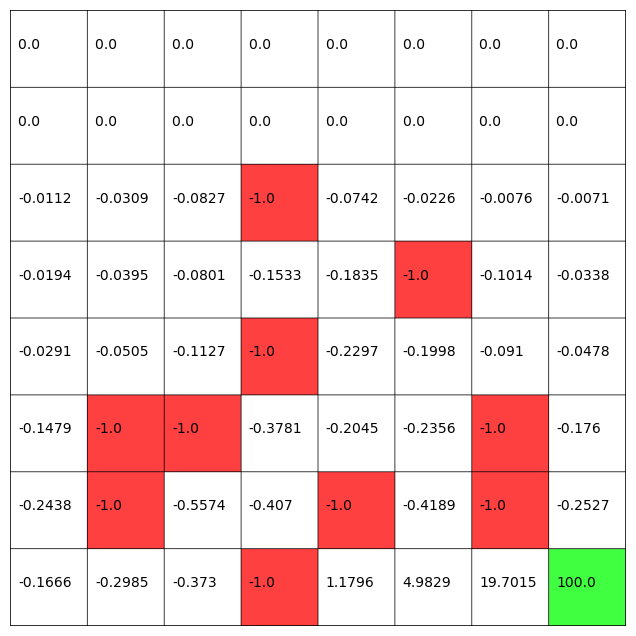

In [5]:
policy = get_constant_policy(problem, dir=0)
policy_state_function = evaluate_policy_state__simulation(problem, policy, n_runs=1000)

print("Policy `always up` state rewards:")
render_policy_state_function(problem, policy_state_function)


Policy `always right` state rewards:


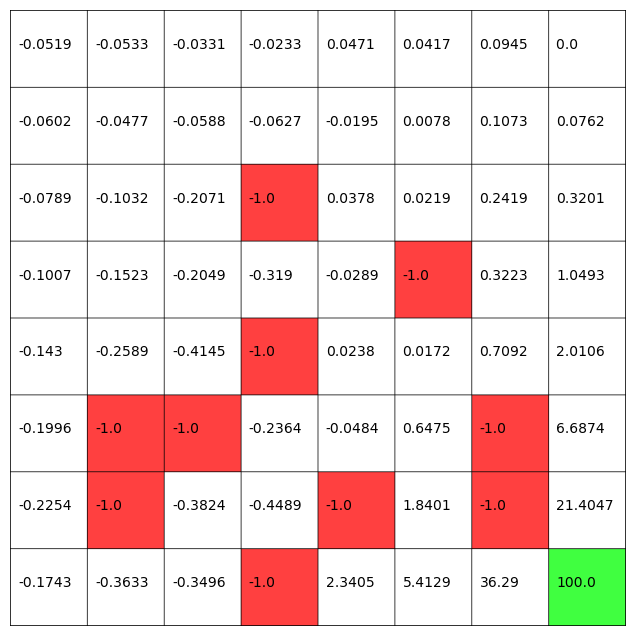

In [6]:
policy = get_constant_policy(problem, dir=1)
policy_state_function = evaluate_policy_state__simulation(problem, policy, n_runs=1000)

print("Policy `always right` state rewards:")
render_policy_state_function(problem, policy_state_function)


Random policy state rewards:


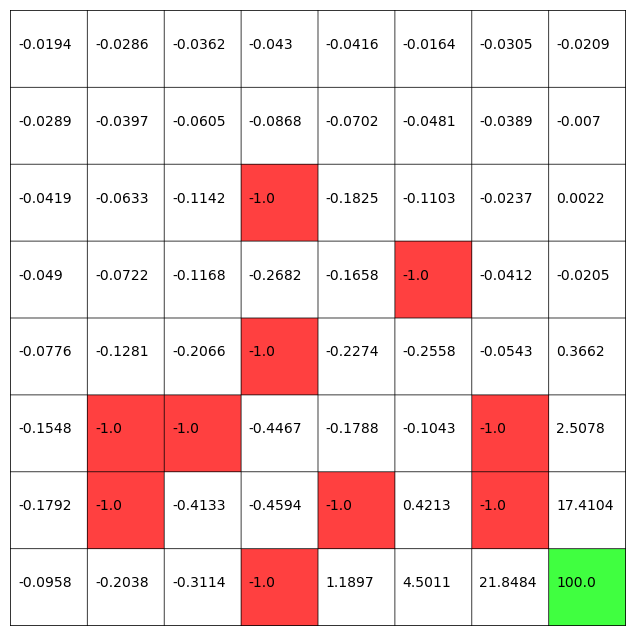

In [7]:
policy = get_random_policy(problem)
policy_state_function = evaluate_policy_state__simulation(problem, policy, n_runs=1000)

print("Random policy state rewards:")
render_policy_state_function(problem, policy_state_function)


## Policy evaluation using two arrays

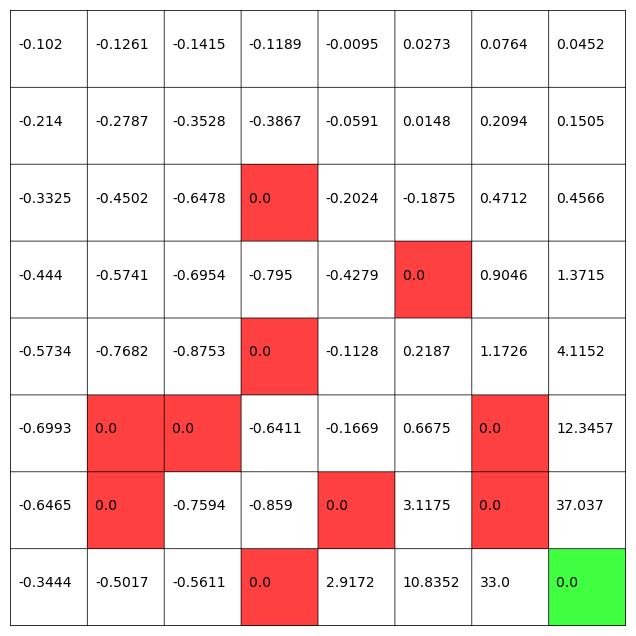

In [8]:
def evaluate_policy_state__two_arrays(problem, policy, n_iters, discount_factor):
    N = problem.N
    board = problem.board

    # Initialize arbitrarily
    policy_state_function = np.random.rand(N, N)

    # Initalize terminal states with zero
    for row, col in np.ndindex(policy_state_function.shape):
        if board[row][col] in 'HG':
            policy_state_function[row, col] = 0

    for step in range(n_iters):
        new_policy_state_function = np.zeros_like(policy_state_function)

        for row, col in np.ndindex(policy_state_function.shape):

            # Skip terminal states
            if board[row][col] in 'HG':
                continue

            for action_idx in range(4):

                # state = (row, col)
                # picked action = action_idx

                # next state decided by picked action and slippery (modify action with probability 1/3)
                for delta_action_idx in range(-1, 2):

                    true_action_idx = (action_idx + delta_action_idx) % 4

                    dr, dc = DIRECTIONS[true_action_idx]
                    next_row, next_col = row + dr, col + dc

                    if 0 <= next_row < N and 0 <= next_col < N:

                        transition_prob = 1.0/3

                        reward, done = problem.get_reward_done(next_row, next_col)

                        new_policy_state_function[row, col] += policy[row, col, action_idx] * transition_prob * (reward + discount_factor * policy_state_function[next_row, next_col])

        policy_state_function = new_policy_state_function

    return policy_state_function

policy = get_constant_policy(problem, dir=1)  # always go right
policy_state_function = evaluate_policy_state__two_arrays(problem, policy, n_iters=1000, discount_factor=0.9)
render_policy_state_function(problem, policy_state_function)

## Policy evaluation in-place

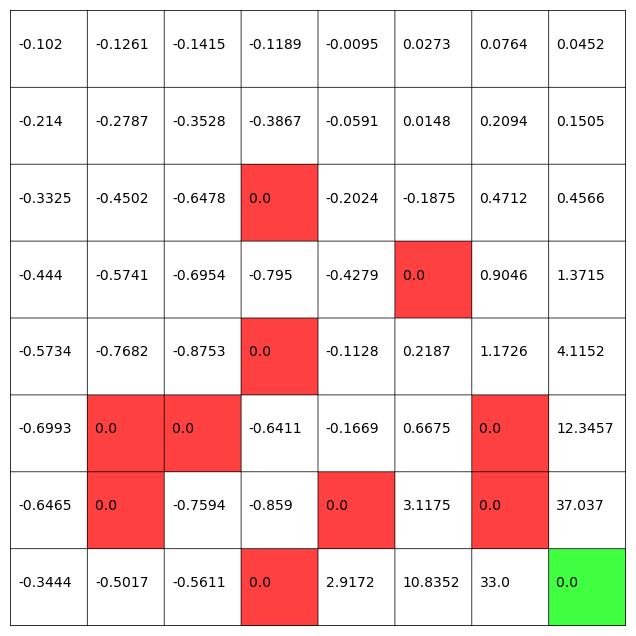

In [9]:
def evaluate_policy_state__in_place(problem, policy, n_iters, discount_factor):
    N = problem.N
    board = problem.board

    # Initialize arbitrarily
    policy_state_function = np.random.rand(N, N)

    # Initalize terminal states with zero
    for row, col in np.ndindex(policy_state_function.shape):
        if board[row][col] in 'HG':
            policy_state_function[row, col] = 0

    for step in range(n_iters):
        for row, col in np.ndindex(policy_state_function.shape):

            # Skip terminal states
            if board[row][col] in 'HG':
                continue

            policy_state_function[row, col] = 0

            for action_idx in range(4):

                # state = (row, col)
                # picked action = action_idx

                # next state decided by picked action and slippery (modify action with probability 1/3)
                for delta_action_idx in range(-1, 2):

                    true_action_idx = (action_idx + delta_action_idx) % 4

                    dr, dc = DIRECTIONS[true_action_idx]
                    next_row, next_col = row + dr, col + dc

                    if 0 <= next_row < N and 0 <= next_col < N:

                        transition_prob = 1.0/3

                        reward, done = problem.get_reward_done(next_row, next_col)

                        policy_state_function[row, col] += policy[row, col, action_idx] * transition_prob * (reward + discount_factor * policy_state_function[next_row, next_col])

    return policy_state_function

policy = get_constant_policy(problem, dir=1)  # always go right
policy_state_function = evaluate_policy_state__in_place(problem, policy, n_iters=1000, discount_factor=0.9)
render_policy_state_function(problem, policy_state_function)

# Policy Iteration

Dynamic Programming solution for the RL problems with finite number of states and finite number of actions

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 80, 4.1 - Policy Iteration

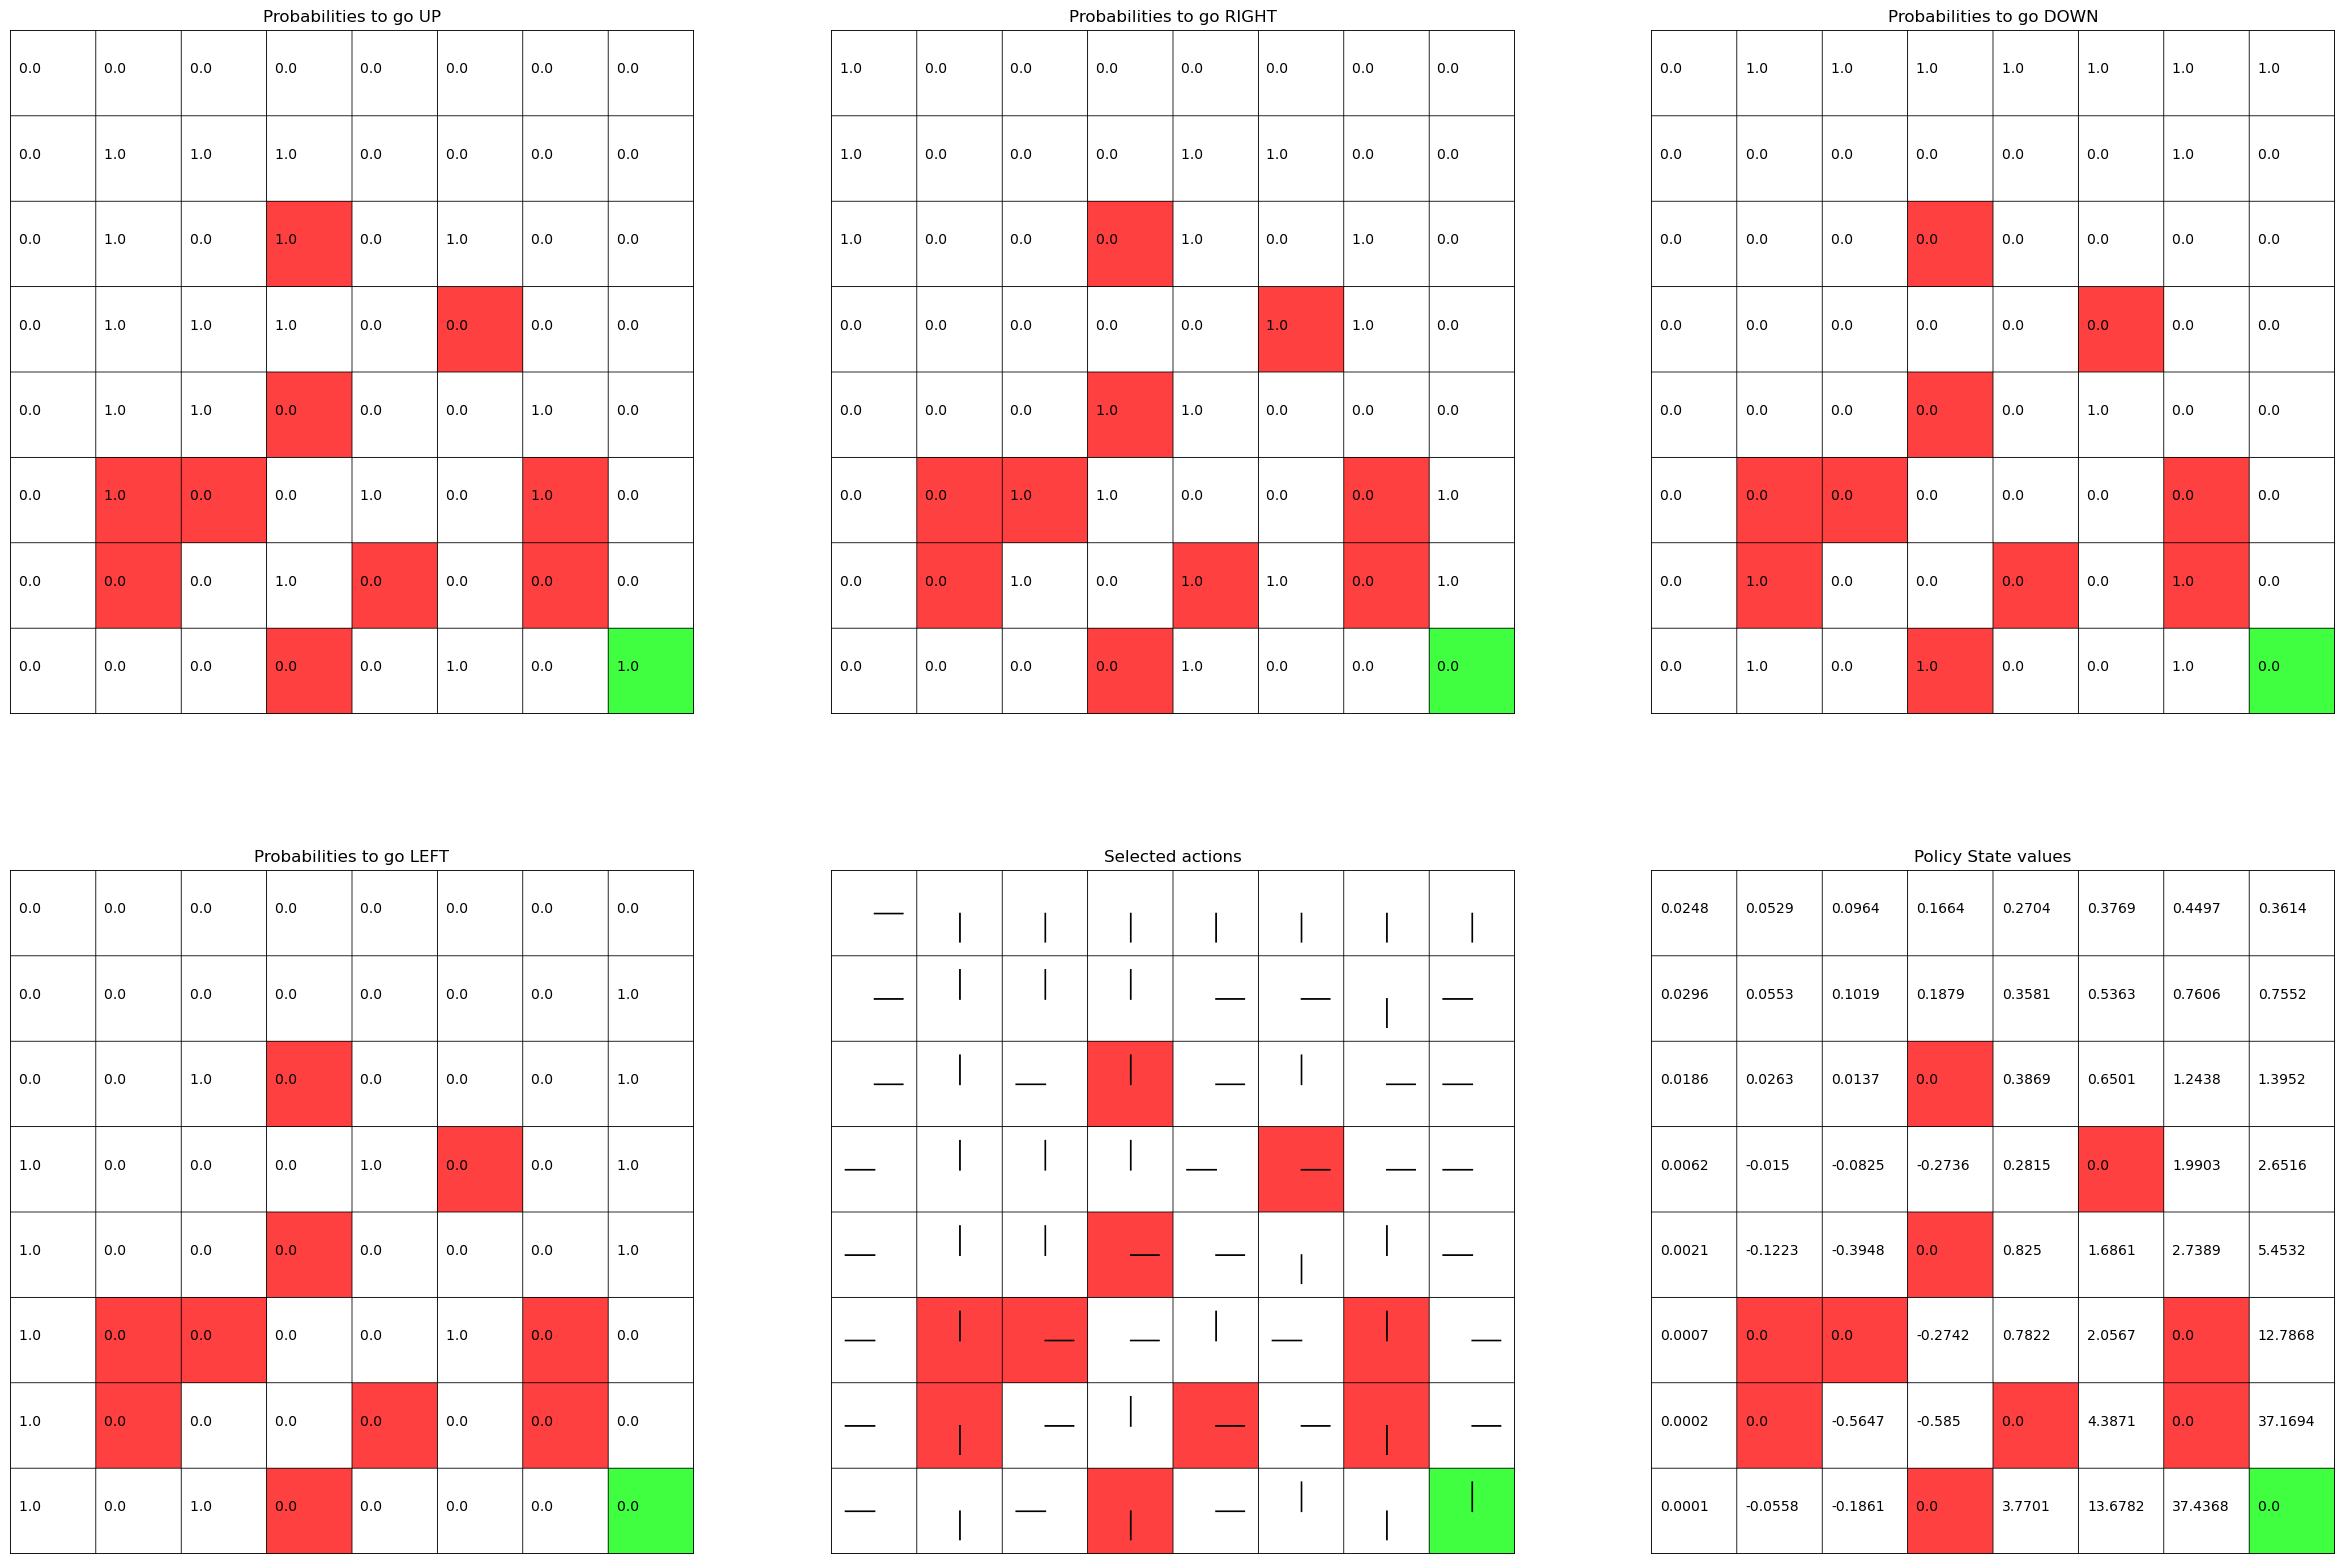

In [32]:
def policy_iteration(problem, accuracy_estimation_threshold, discount_factor):
    N = problem.N
    board = problem.board

    # Initialize arbitrarily
    policy = get_random_policy(problem)
    policy_state_function = np.random.rand(N, N)

    # Initalize terminal states with zero
    for row, col in np.ndindex(policy_state_function.shape):
        if board[row][col] in 'HG':
            policy_state_function[row, col] = 0
            policy[row, col, :] = 0

    while True:

        # Policy Evaluation
        while True:
            delta = 0
            for row, col in np.ndindex(policy_state_function.shape):

                # Skip terminal states
                if board[row][col] in 'HG':
                    continue

                old_value = policy_state_function[row, col]

                policy_state_function[row, col] = 0

                for action_idx in range(4):

                    # state = (row, col)
                    # picked action = action_idx

                    # next state decided by picked action and slippery (modify action with probability 1/3)
                    for delta_action_idx in range(-1, 2):

                        true_action_idx = (action_idx + delta_action_idx) % 4

                        dr, dc = DIRECTIONS[true_action_idx]
                        next_row, next_col = row + dr, col + dc

                        if 0 <= next_row < N and 0 <= next_col < N:

                            transition_prob = 1.0/3

                            reward, done = problem.get_reward_done(next_row, next_col)

                            policy_state_function[row, col] += policy[row, col, action_idx] * transition_prob * (reward + discount_factor * policy_state_function[next_row, next_col])

                delta = max(delta, abs(old_value - policy_state_function[row, col]))

            if delta < accuracy_estimation_threshold:
                break

        # Policy Improvement
        policy_stable = True
        for row, col in np.ndindex(policy_state_function.shape):
            old_action = np.argmax(policy[row, col, :])

            rewards = [0] * 4

            for action_idx in range(4):

                for delta_action_idx in range(-1, 2):

                    true_action_idx = (action_idx + delta_action_idx) % 4

                    dr, dc = DIRECTIONS[true_action_idx]
                    next_row, next_col = row + dr, col + dc

                    if 0 <= next_row < N and 0 <= next_col < N:

                        transition_prob = 1.0/3

                        reward, done = problem.get_reward_done(next_row, next_col)

                        rewards[action_idx] += transition_prob * (reward + discount_factor * policy_state_function[next_row, next_col])

            new_action = np.argmax(rewards)

            policy[row, col, :] = 0
            policy[row, col, new_action] = 1

            if old_action != new_action:
                policy_stable = False

        if policy_stable:
            break

    return policy, policy_state_function

def show_policy_and_policy_state_function(problem, policy, policy_state_function):

    def __show_board(values_array, ax, title, show_actions, show_values):
        N, M = values_array.shape
        CELL_SIZE = 100

        img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 255

        for r, c in np.ndindex(values_array.shape):
            colors = {
                'F': [255, 255, 255],
                'H': [255, 64, 64],
                'G': [64, 255, 64],
            }
            img[r * CELL_SIZE : (r + 1) * CELL_SIZE, c * CELL_SIZE : (c + 1) * CELL_SIZE, :] = colors[problem.board[r][c]]

        for r in range(N + 1):
            img[r * CELL_SIZE, :, :] = 0
        for c in range(M + 1):
            img[:, c * CELL_SIZE, :] = 0

        if show_actions:
            for r, c in np.ndindex(values_array.shape):
                rpos = r * CELL_SIZE + CELL_SIZE // 2
                cpos = c * CELL_SIZE + CELL_SIZE // 2

                action = np.argmax(policy[r, c, :])
                dr, dc = DIRECTIONS[action]

                r1 = rpos + dr * CELL_SIZE // 3
                c1 = cpos + dc * CELL_SIZE // 3

                img[min(rpos, r1) : max(rpos, r1) + 2, min(cpos, c1) : max(cpos, c1) + 2, :] = 0

        ax.imshow(img)
        ax.axis('off')
        if show_values:
            for r, c in np.ndindex(values_array.shape):
                x = c * CELL_SIZE + CELL_SIZE // 10
                y = r * CELL_SIZE + CELL_SIZE // 2
                s = "{0:<4}".format(str(round(values_array[r, c], 4)))
                ax.text(x, y, s)

        ax.set_title(title)

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(30, 20)
    ax = ax.reshape(-1, 3)

    __show_board(policy[:, :, 0], ax[0, 0], "Probabilities to go UP", show_actions=False, show_values=True)
    __show_board(policy[:, :, 1], ax[0, 1], "Probabilities to go RIGHT", show_actions=False, show_values=True)
    __show_board(policy[:, :, 2], ax[0, 2], "Probabilities to go DOWN", show_actions=False, show_values=True)
    __show_board(policy[:, :, 3], ax[1, 0], "Probabilities to go LEFT", show_actions=False, show_values=True)
    __show_board(policy_state_function, ax[1, 1], "Selected actions", show_actions=True, show_values=False)
    __show_board(policy_state_function, ax[1, 2], "Policy State values", show_actions=False, show_values=True)

policy, policy_state_function = policy_iteration(problem, accuracy_estimation_threshold=1e-5, discount_factor=0.9)
show_policy_and_policy_state_function(problem, policy, policy_state_function)